In [40]:
import pandas as pd
import dask.bag as db
import dask.dataframe as dd
import json
import datetime

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [81]:
posts = (db.read_text('posts/file*.jsonl')
           .map(json.loads))

In [82]:
n_items = posts.map(lambda x: 1).sum()

In [83]:
n_items_computed = n_items.compute()
print("Number of posts, total", n_items_computed)

Number of posts, total 227290


In [84]:
freq = posts.pluck('group').frequencies()

In [85]:
%%time
freq_comp = freq.compute()

CPU times: user 36.5 ms, sys: 69 ms, total: 105 ms
Wall time: 8.14 s


Text(0, 0.5, 'Group')

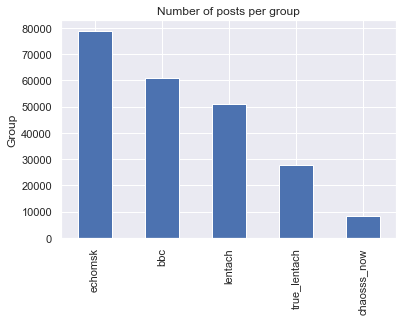

In [86]:
(pd.Series(dict(freq_comp))
   .sort_values(ascending=False)
   .plot
   .bar())

plt.title('Number of posts per group')
plt.ylabel('Number of posts')
plt.ylabel("Group")

In [87]:
def flatten(x):
    y = {}
    y['group'] = x['group']
    y['date'] = x['date']
    y['text'] = x['text']
    y['likes'] = x['likes']['count']
    y['reposts'] = x['reposts']['count']
    y['views'] = x['views']['count'] if "views" in y else -1
    y['marked_as_ads'] = bool(x['marked_as_ads'])
    return y

posts_flattened = posts.map(flatten)

ddf = (posts_flattened.to_dataframe()
                      .astype({'group': 'category', 
                               'text': 'string'})
                      .repartition(npartitions=12))

In [88]:
df = ddf.compute()

In [99]:
df.index = range(len(df))

In [96]:
df.shape

'Хэй, Лентач. Как вы знаете, к этому сообществу была куча претензий. И все это закончилось тем, чем закончилось. Предпоследним распоряжением главного редактора Гали Тимченко этот паблик был лишен статуса официального. У новой "Ленты.ру" отныне другая официальная и верифицированная страница. Все, что там происходит, уже не на нашей совести. А теперь выполним самое последнее распоряжение Тимченко. Паблик продолжит жить для своих читателей и вместе с ними. Это уже не Лента, но это все еще Лентач.'

In [100]:
mem_usg = df.memory_usage(deep=True) / 1024 ** 2
mem_usg

Index            0.000122
group            0.217223
date             1.734085
text             1.734085
likes            1.734085
reposts          1.734085
views            1.734085
marked_as_ads    0.216761
dtype: float64

In [109]:
df.to_csv('data/news.csv', index=False)

In [116]:
df.text = df.text.astype('object')

In [119]:
df.to_parquet('data/news.parq', partition_cols=['group'])

/Users/u17518516/.conda/envs/news-research/lib/python3.7/site-packages/pyarrow/pandas_compat.py:383: FutureWarning: RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead
  'start': level._start,
/Users/u17518516/.conda/envs/news-research/lib/python3.7/site-packages/pyarrow/pandas_compat.py:384: FutureWarning: RangeIndex._stop is deprecated and will be removed in a future version. Use RangeIndex.stop instead
  'stop': level._stop,
/Users/u17518516/.conda/envs/news-research/lib/python3.7/site-packages/pyarrow/pandas_compat.py:385: FutureWarning: RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead
  'step': level._step


In [118]:
! rm data/news.parq